[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# The g-h Filter

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()

Before we continue, some words about using Jupyter Notebooks with this book. This book is interactive. If you want to run code examples, and especially if you want to see animated plots, you will need to run the code cells. I cannot teach you everything about Jupyter Notebooks. However, a few things trip readers up. You can go to http://jupyter.org/ for detailed documentation.

First, you must always run the topmost code cell, the one with the comment `#format the book`. It is directly above. This does not just set up formatting, which you might not care about, but it also loads some necessary modules and makes some global settings regarding plotting and printing. So, always run this cell unless you are just passively reading. The import from `__future__` helps Python 2.7 work like Python 3.X. Division of integers will return a `float` (`3/10 == 0.3`) instead of an `int` (`3/10 == 0`), and printing requires parens: `print(3)`, not `print 3`. The line

```python
%matplotlib inline
```
causes plots to be displayed inside the noteboook. For reasons I don't understand the default behavior of Jupyter Notebooks is to generate plots in an external window. 

Running a cell is easy. Click on it so that it has focus (a box will be drawn around it), and then press CTRL-Enter. 

Second, cells must be run in order. I break problems up over several cells; if you try to just skip down and run the tenth code cell it almost certainly won't work. If you haven't run anything yet just choose *Run All Above* from the **Cell** menu item. That's the easiest way to ensure everything has been run.

Once cells are run you can often jump around and rerun cells in different orders, but not always. I'm trying to fix this, but there is a tradeoff. I'll define a variable in cell 10 (say), and then run code that modifies that variable in cells 11 and 12. If you go back and run cell 11 again the variable will have the value that was set in cell 12, and the code expects the value that was set in cell 10. So, occasionally you'll get weird results if you run cells out of order. My advise is to backtrack a bit, and run cells in order again to get back to a proper state. It's annoying, but the interactive aspect of Jupyter notebooks more than makes up for it. Better yet, submit an issue on GitHub so I know about the problem and fix it!

Finally, some readers have reported problems with the animated plotting features in some browsers. I have not been able to duplicate this. In the code cell above `%matplot notebook` enables the interactive plots. If plots are not working for you, try changing this to read `%matplotlib inline`. You will lose the animated plotting, but it seems to work on all platforms and browsers.

## Building Intuition via Thought Experiments

Imagine that we live in a world without scales - the devices you stand on to weigh yourself. One day at work a co-worker comes running up to you and announces her invention of a 'scale' to you. After she explains, you eagerly stand on it and announce the results: "172 lbs". You are ecstatic - for the first time in your life you know what you weigh. More importantly, dollar signs dance in your eyes as you imagine selling this device to weight loss clinics across the world! This is fantastic!

Another co-worker hears the commotion and comes over to find out what has you so excited. You explain the invention and once again step onto the scale, and proudly proclaim the result: "161 lbs." And then you hesitate, confused.

"It read 172 lbs a few seconds ago" you complain to your co-worker. 

"I never said it was accurate," she replies.

Sensors are inaccurate. This is the motivation behind a huge body of work in filtering, and solving this problem is the topic of this book. I could just provide the solutions that have been developed over the last half century, but these solutions were developed by asking very basic, fundamental questions into the nature of what we know and how we know it. Before we attempt the math, let's follow that journey of discovery, and see if it does not inform our intuition about filtering. 

**Try Another Scale**

Is there any way we can improve upon this result? The obvious, first thing to try is get a better sensor. Unfortunately, your co-worker informs you that she has built 10 scales, and they all operate with about the same accuracy. You have her bring out another scale, and you weigh yourself on one, and then on the other. The first scale (A) reads "160 lbs", and the second (B) reads "170 lbs". What can we conclude about your weight?

Well, what are our choices?

* We could choose to only believe A, and assign 160lbs to our weight estimate.
* We could choose to only believe B, and assign 170lbs to our weight.
* We could choose a number less than either A or B.
* We could choose a number greater than either A or B.
* We could choose a number between A and B.

The first two choices are plausible, but we have no reason to favor one scale over the other. Why would we choose to believe A instead of B? We have no reason for such a belief. The third and fourth choices are irrational. The scales are admittedly not very accurate, but there is no reason at all to choose a number outside of the range of what they both measured. The final choice is the only reasonable one. If both scales are inaccurate, and as likely to give a result above my actual weight as below it, more often than not probably the answer is somewhere between A and B. 

In mathematics this concept is formalized as [*expected value*](https://en.wikipedia.org/wiki/Expected_value), and we will cover it in depth later. For now ask yourself what would be the 'usual' thing to happen if we took one million readings. Some of the times both scales will read too low, sometimes both will read too high, and the rest of the time they will straddle the actual weight. If they straddle the actual weight then certainly we should choose a number between A and B. If they don't straddle then we don't know if they are both too high or low, but by choosing a number between A and B we at least mitigate the effect of the worst measurement. For example, suppose our actual weight is 180 lbs. 160 lbs is a big error. But if we choose a weight between 160 lbs and 170 lbs our estimate will be better than 160 lbs. The same argument holds if both scales returned a value greater than the actual weight.

We will deal with this more formally later, but for now I hope it is clear that our best estimate is the average of A and B. $\frac{160+170}{2} = 165$.

We can look at this graphically. I have plotted the measurements of A and B with an assumed error of $\pm$ 8 lbs. The overlap falls between 160 and 170 so the only weight that makes sense must lie within 160 and 170 pounds. 

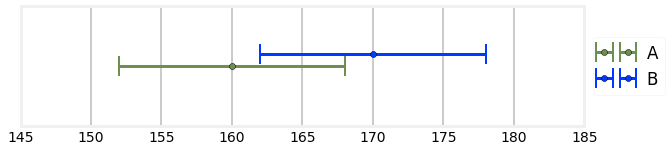

In [2]:
from kf_book.book_plots import figsize, plot_errorbars
with figsize(y=2):
    plot_errorbars([(160, 8, 'A'), (170, 8, 'B')],
                   xlims=(145, 185), ylims=(-1, 1));

So 165 lbs looks like a reasonable estimate, but there is more information here that we might be able to take advantage of. The only weights that are possible lie in the intersection between the error bars of A and B. For example, a weight of 161 lbs is impossible because scale B could not give a reading of 170 lbs with a maximum error of 8 pounds. Likewise a weight of 171 lbs is impossible because scale A could not give a reading of 160 lbs with a maximum error of 8 lbs. In this example the only possible weights lie in the range of 162 to 168 lbs.

That doesn't yet allow us to find a better weight estimate, but let's play 'what if' some more. What if we are now told that A is three times more accurate than B? Consider the 5 options we listed above. It still makes no sense to choose a number outside the range of A and B, so we will not consider those. It perhaps seems more compelling to choose A as our estimate - after all, we know it is more accurate, why not use it instead of B? Can B possibly improve our knowledge over A alone?

The answer, perhaps counter intuitively, is yes, it can. First, let's look at the same measurements of A=160 and B=170, but with the error of A $\pm$ 3 lbs and the error of B is 3 times as much, $\pm$ 9 lbs.

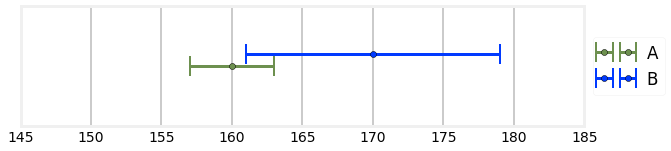

In [3]:
with figsize(y=2):
    plot_errorbars([(160, 3, 'A'), (170, 9, 'B')],
                   xlims=(145, 185), ylims=(-1, 1))

The overlap of the error bars of A and B are the only possible true weight. This overlap is smaller than the error in A alone. More importantly, in this case we can see that the overlap doesn't include 160 lbs or 165 lbs. If we only used the measurement from A because it is more accurate than B we would give an estimate of 160 lbs. If we average A and B we would get 165 lbs. Neither of those weights are possible given our knowledge of the accuracy of the scales. By including the measurement of B we would give an estimate somewhere between 161 lbs and 163 lbs, the limits of the intersections of the two error bars.

Let's take this to the extreme limits.  Assume we know scale A is accurate to 1 lb. In other words, if we truly weigh 170 lbs, it could report 169, 170, or 171 lbs. We also know that scale B is accurate to 9 lbs. We do a weighing on each scale, and get A=160, and B=170. What should we estimate our weight to be? Let's look at that graphically.

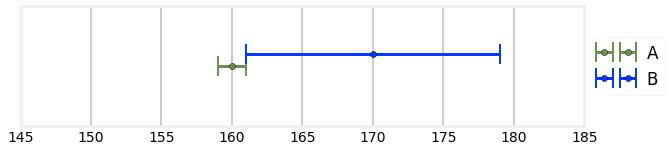

In [4]:
with figsize(y=2):
    plot_errorbars([(160, 1, 'A'), (170, 9, 'B')],
                   xlims=(145, 185), ylims=(-1, 1))

Here we can see that the only possible weight is 161 lbs. This is an important result. With two relatively inaccurate sensors we are able to deduce an extremely accurate result.

So two sensors, even if one is less accurate than the other, is better than one.

However, we have strayed from our problem. No customer is going to want to buy multiple scales, and besides, we initially started with an assumption that all scales were equally (in)accurate. This insight of using all measurements regardless of accuracy will play a large role later, so don't forget it.

What if I have one scale, but I weigh myself many times? We concluded that if we had two scales of equal accuracy we should average the results of their measurements. What if I weigh myself 10,000 times with one scale? We have already stated that the scale is equally likely to return a number too large as it is to return one that is too small. It is not that hard to prove that the average of a large number of weights will be very close to the actual weight, but let's write a simulation for now.

In [5]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
print('Average of measurements is {:.4f}'.format(
      measurements.mean()))

Average of measurements is 164.9963


The exact number printed depends on your random number generator, but it should be very close to 165.

If this is your first time using Jupyter Notebook, the code below is in a *cell*. The text "In [2]:" labels this as a cell where you can enter input, and the number in the bracket denotes that this cell was run second. To run the cell, click on it with your mouse so that it has focus, then press CTRL+ENTER on the keyboard. As we continue you will be able to alter the code inside the cells and rerun them. Try changing the values "160", "170", and "10000" to some other value and run the cell. The printed output should change depending on what you entered.

This code makes one assumption that probably isn't true - that the scale is as likely to read 160 as 165 for a true weight of 165 lbs. This is almost never true. Real sensors are more likely to get readings nearer the true value, and are less and less likely to get readings the further away from the true value it gets. We will cover this in detail in the Gaussian chapter. For now, I will use without further explanation the `numpy.random.normal()` function, which will produce more values nearer 165 lbs, and fewer further away. Take it on faith for now that this will produce noisy measurements very similar to how a real scale would.

In [6]:
measurements = np.random.normal(165, 5, size=10000)
print('Average of measurements is {:.4f}'.format(
      measurements.mean()))

Average of measurements is 165.0785


The answer again is very close to 165. 

Okay, great, we have an answer to our sensor problem! But it is not a very practical answer. No one has the patience to weigh themselves ten thousand, or even a dozen times. 

So, let's play 'what if' again. What if you measured your weight once a day, and got the readings 170, 161, and then 169. Did you gain weight, lose weight, or is this all just noisy measurements? 

We really can't say. The first measurement was 170, and the last was 169, implying a 1 lb loss. But if the scale is only accurate to 10 lbs, that is explainable by noise. I could have actually gained weight; maybe my weight on day one was 165 lbs, and on day three it was 172. It is possible to get those weight readings with that weight gain. My scale tells me I am losing weight, and I am actually gaining weight! Let's look at that in a chart. I've plotted the measurements along with the error bars, and then some possible weight gain/losses that could be explained by those measurements in dotted green lines.
<img src="./figs/gh_hypothesis1.png">

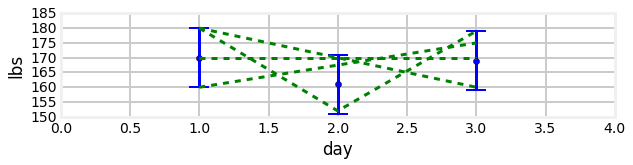

In [7]:
import kf_book.book_plots as book_plots
book_plots.plot_hypothesis1()

As we can see there is an extreme range of weight changes that could be explained by these three measurements. Shall we give up? No. Recall that we are talking about measuring a humans' weight. There is no way for a human to weigh 180 lbs on day 1, and 160 lbs on day 3. or to lose 30 lbs in one day only to gain it back the next (we will assume no amputations or other trauma has happened to the person). The behavior of the physical system we are measuring should influence how we interpret the measurements. 
 
Suppose I take a different scale, and I get the following measurements: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170. What does your intuition tell you? It is possible, for example, that you gained 1 lb each day, and the noisy measurements just happens to look like you stayed the same weight. Equally, you could have lost 1 lb a day and gotten the same readings. But is that likely? How likely is it to flip a coin and get 10 heads in a row? Not very likely. We can't prove it based solely on these readings, but it seems pretty likely that my weight held steady. In the chart below I've plotted the measurements with error bars, and a likely true weight in dashed green. This dashed line is not meant to be the 'correct' answer to this problem, merely one that is reasonable and could be explained by the measurement.

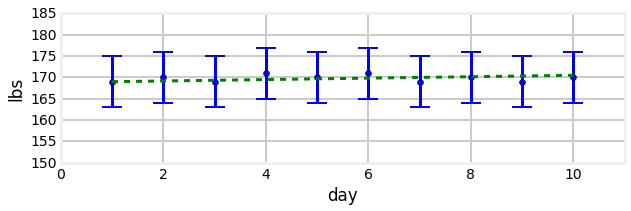

In [8]:
book_plots.plot_hypothesis2()

Another what if: what if the readings were 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? Let's look at a chart of that and then answer some questions.

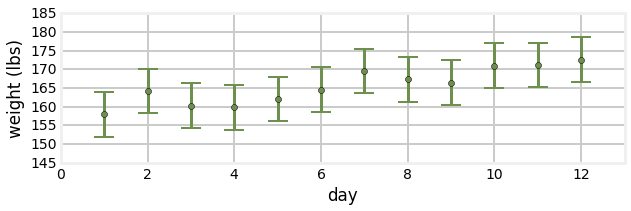

In [9]:
book_plots.plot_hypothesis3()

Does it 'seem' likely that I lost weight and this is just really noisy data? Not really. Does it seem likely that I held the same weight? Again, no. This data trends upwards over time; not evenly, but definitely upwards. We can't be sure, but that surely looks like a weight gain, and a significant weight gain at that. Let's test this assumption with some more plots. It is often easier to 'eyeball' data in a chart versus a table.

So let's look at two hypotheses. First, let's assume our weight did not change. To get that number we agreed that we should average the measurements. Let's look at that.


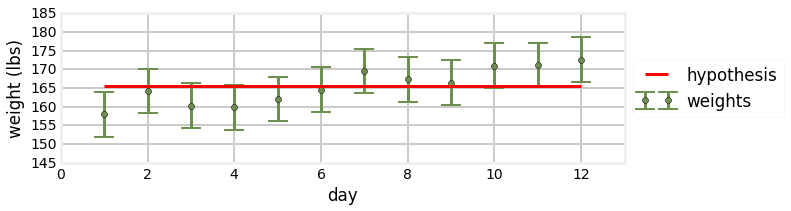

In [10]:
book_plots.plot_hypothesis4()

That doesn't look very convincing. In fact, we can see that there is no horizontal line that we could draw that is inside all of the error bars.

Now, let's assume we gained weight. How much? I don't know, but numpy does! We want to draw a line through the measurements that looks 'about' right. numpy has functions that will do this according to a rule called "least squares fit". Let's not worry about the details of that computation, or why we are writing our own filter if numpy provides one, and plot the results.

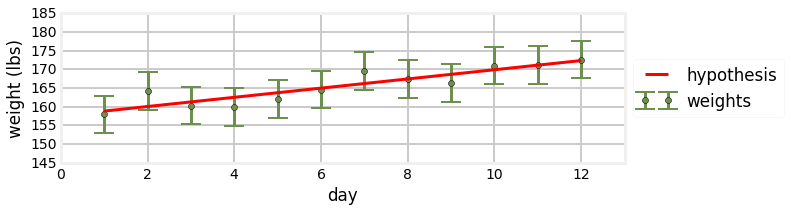

In [11]:
book_plots.plot_hypothesis5()

This looks much better, at least to my eyes. Notice now the hypothesis lies very close to each measurement, whereas in the previous plot the hypothesis was often quite far from the measurement. It seems far more likely to be true that I gained weight than I didn't gain any weight. Did I actually gain 13 lbs? Who can say? That seems impossible to answer.

"But is it impossible?" pipes up a co-worker.

Let's try something crazy. Let's assume that I know I am gaining about one lb a day. It doesn't matter how I know that right now, assume I know it is approximately correct. Maybe I am eating a 6000 calorie a day diet, which would result in such a weight gain. Or maybe there is another way to estimate the weight gain. Let's see if we can make use of such information if it was available without worrying about the source of that information yet.

The first measurement was 158. We have no way of knowing any different, so let's accept that as our estimate. If our weight today is 158, what will it be tomorrow? Well, we think we are gaining weight at 1 lb/day, so our prediction is 159, like so:

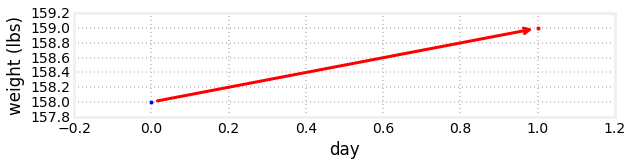

In [12]:
book_plots.plot_estimate_chart_1()

Okay, but what good is this? Sure, we could assume the 1 lb/day is accurate, and predict our weight for the next 10 days, but then why use a scale at all if we don't incorporate its readings? So let's look at the next measurement. We step on the scale again and it displays 164.2 lbs.

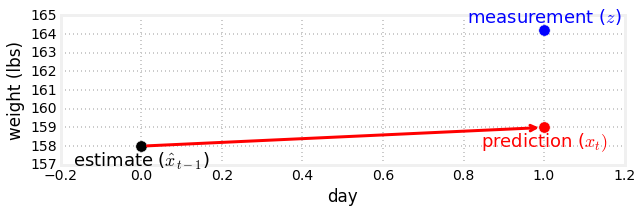

In [13]:
book_plots.plot_estimate_chart_2()

We have a problem. Our prediction doesn't match our measurement. But, that is what we expected, right? If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter. 

> The key insight to this entire book is in the next paragraph. Read it carefully!

So what do we do? If we only take data from the measurement then the prediction will not affect the result. If we only take data from the prediction then the measurement will be ignored. If this is to work we need to take some kind of *blend of the prediction and measurement* (I've italicized the key point).

Blending two values - this sounds a lot like the two scale problem earlier. Using the same reasoning as before we can see that the only thing that makes sense is to choose a number between the prediction and the measurement. For example, an estimate of 165 makes no sense, nor does 157. Our estimates should lie between 159 (the prediction) and 164.2 (the measurement).

Should it be half way? Maybe, but in general it seems like we might know that our prediction is more or less accurate compared to the measurements. Probably the accuracy of our prediction differs from the accuracy of the scale. Recall what we did when scale A was much more accurate than scale B - we scaled the answer to be closer to A than B. Let's look at that in a chart.

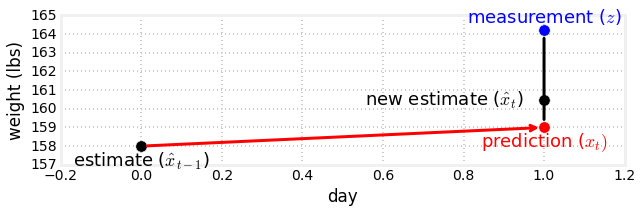

In [14]:
book_plots.plot_estimate_chart_3()

Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$\mathtt{new\_estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

The difference between the measurement and prediction is called the *residual*, which is depicted by the black vertical line in the plot above. This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output. Smaller residuals imply better performance.

Let's code that and see the results when we test it against the series of weights from above. We have to take into account one other factor. Weight gain has units of lbs/time, so to be general we will need to add a time step $t$, which we will set to 1 (day). 

I hand generated the weight data to correspond to a true starting weight of 160 lbs, and a weight gain of 1 lb per day. In other words on the first day (day zero) the true weight is 160lbs, on the second day (day one, the first day of weighing) the true weight is 161 lbs, and so on. 

We need to make a guess for the initial weight. It is too early to talk about initialization strategies, so for now I will assume 160 lbs.

previous: 160.00, prediction: 161.00 estimate 159.80
previous: 159.80, prediction: 160.80 estimate 162.16
previous: 162.16, prediction: 163.16 estimate 162.02
previous: 162.02, prediction: 163.02 estimate 161.77
previous: 161.77, prediction: 162.77 estimate 162.50
previous: 162.50, prediction: 163.50 estimate 163.94
previous: 163.94, prediction: 164.94 estimate 166.80
previous: 166.80, prediction: 167.80 estimate 167.64
previous: 167.64, prediction: 168.64 estimate 167.75
previous: 167.75, prediction: 168.75 estimate 169.65
previous: 169.65, prediction: 170.65 estimate 170.87
previous: 170.87, prediction: 171.87 estimate 172.16


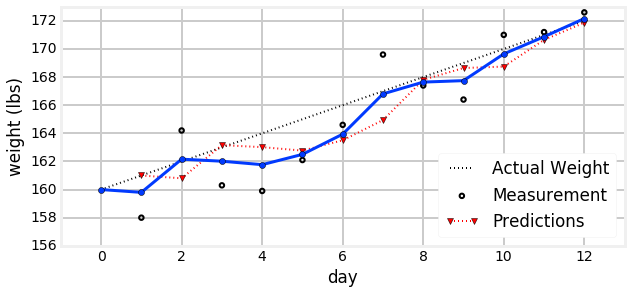

In [15]:
from book_format import set_figsize
from kf_book import book_plots
import kf_book.gh_internal as gh
import matplotlib.pyplot as plt


weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0 # day
scale_factor = 4.0/10

def predict_using_gain_guess(weight, gain_rate, do_print=True, sim_rate=0): 
    set_figsize(y=4)
    # store the filtered results
    estimates, predictions = [weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        prediction = weight + gain_rate * time_step

        # update filter 
        weight = prediction + scale_factor * (z - prediction)

        # save
        estimates.append(weight)
        predictions.append(prediction)
        if do_print:
            gh.print_results(estimates, prediction, weight)

    # plot results
    gh.plot_gh_results(weights, estimates, predictions, sim_rate)
    
initial_guess = 160.
predict_using_gain_guess(weight=initial_guess, gain_rate=1)    

That is pretty good! There is a lot of data here, so let's talk about how to interpret it.  The thick blue line shows the estimate from the filter. It starts at day 0 with the initial guess of 160 lbs. The red line shows the prediction that is made from the previous day's weight. So, on day one the previous weight was 160 lbs, the weight gain is 1 lb, and so the first prediction is 161 lbs. The estimate on day one is then part way between the prediction and measurement at 159.8 lbs. Below the chart is a print out of the previous weight, predicted weight, and new estimate for each day. Finally, the thin black line shows the actual weight gain of the person being weighed. 

The estimates are not a straight line, but they are straighter than the measurements and somewhat close to the trend line we created. Also, it seems to get better over time. 

Before I go on, let me show this plot interactively so you get a better feel for how the filter works. Put your cursor inside the next cell and press CTRL+Enter to execute the cell. This will cause the plot to be drawn slowly, step by step.

<IPython.core.display.Javascript object>


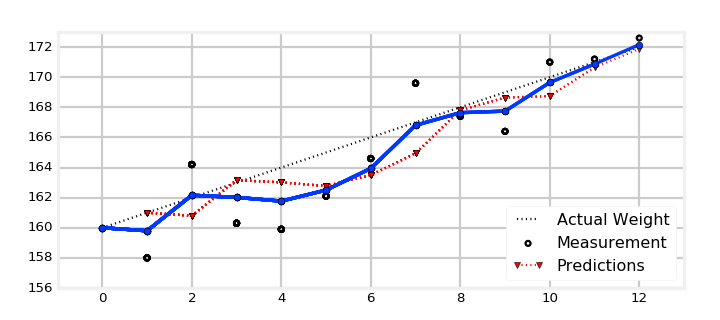

In [16]:
%matplotlib notebook
predict_using_gain_guess(weight=initial_guess, gain_rate=1., do_print=False, sim_rate=.4)
%matplotlib inline

You can see each step of the process. The filter makes a prediction, and then takes a measurement. From these it forms an estimate between the two.

I will use this technique many times in the book. You can control the rate of drawing with the `sim_rate` parameter, which specifies the delay in seconds between subsequent draws. You may change it to whatever value you prefer. If you make it too large the drawing might take a very long time to finish. Just select `Kernel\Interrupt` from the menu if it is taking too long.

While we are discussing this code, let's talk about interactive plots. You can create interactive plots in Jupyter notebooks with the
    
    %matplotlib notebook
    
magic that I put at the top of this file. Interactive plots don't just allow animations as in the above plots, they also allow you to pan and zoom the plots, and display the coordinates of the mouse. Once the plot is done I put the line

    %matplotlib inline

to return to the static form of plotting. You can remove this line if you want. I always do it because the plot must be in static form to be converted to PDF format, which I do for the printed version of this book.

If you are reading this in a PDF than you will see the interactive code commented out. I wrote a batch file that does this automatically. 

To get the animation to work you have to call `plt.gcf().canvas.draw()` each time you want an update, and call `time.sleep()` to slow down the animation. If you look at the code in `gh.plot_gh_results()` you'll see it using this to create the animation. For example, the following code draws a line once a second:

<IPython.core.display.Javascript object>


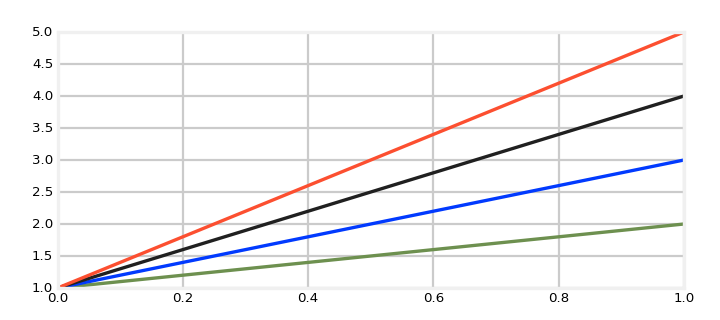

In [17]:
import time
%matplotlib notebook

for x in range(2,6):
    plt.plot([0, 1], [1, x])
    plt.gcf().canvas.draw()
    time.sleep(1)

%matplotlib inline 

Back to filtering. The results of the filter may strike you as quite silly; of course the data will look good if we assume the conclusion, that our weight gain is around 1 lb/day! Let's see what the filter does if our initial guess is bad. Let's predict that there is a weight loss of 1 lb a day:

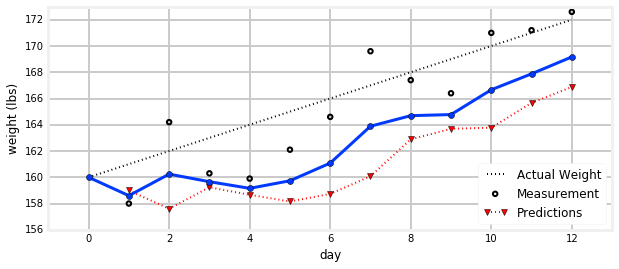

In [18]:
predict_using_gain_guess(initial_guess, -1., do_print=False)

That is not so impressive. Clearly a filter that requires us to correctly guess a rate of change is not very useful. Even if our initial guess was correct, the filter will fail as soon as that rate of change changes. If I stop overeating the filter will have extreme difficulty in adjusting to that change. 

But, 'what if'? What if instead of leaving the weight gain at the initial guess of 1 lb (or whatever), we compute it from the existing measurements and estimates. On day one our estimate for the weight is:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

On the next day we measure 164.2, which implies a weight gain of 4.4 lbs (since 164.2 - 159.8 = 4.4), not 1. Can we use this information somehow? It seems plausible. After all, the weight measurement itself is based on a real world measurement of our weight, so there is useful information. Our estimate of our weight gain may not be perfect, but it is surely better than just guessing our gain is 1 lb. Data is better than a guess, even if it is noisy.

So, should we set the new gain/day to 4.4 lbs? Yesterday we though the weight gain was 1 lb, today we think it is 4.4 lbs. We have two numbers, and want to combine them somehow. Hmm, sounds like our same problem again. Let's use our same tool, and the only tool we have so far - pick a value part way between the two. This time I will use another arbitrarily chosen number, $\frac{1}{3}$. The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day):

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

<IPython.core.display.Javascript object>


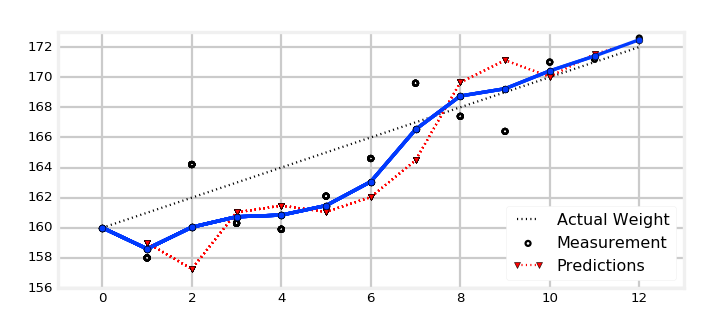

In [19]:
weight = 160.  # initial guess
gain_rate = -1.0 # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

%matplotlib notebook
gh.plot_gh_results(weights, estimates, predictions, time_step=0.1)
%matplotlib inline

I think this is starting to look really good. Because of the poor initial guess of the weight gain it takes the filter several days to accurately predict the weight, but once it does that it starts to accurately track the weight. We used no methodology for choosing our scaling factors of $\frac{4}{10}$ and $\frac{1}{3}$ (actually, they are poor choices for this problem), but otherwise all of the reasoning followed from very reasonable assumptions. Recall that you can change the value of the parameter `time_step` to a larger value and re-run the cell if you want to see the plot drawn step-by-step.

One final point before we go on. In the prediction step I wrote the line
```python
gain_rate = gain_rate
``` 
This obviously has no effect, and can be removed. I wrote this to emphasize that in the prediction step you need to predict next value for all variables, both `weight` and `gain_rate`. In this case we are assuming that the gain does not vary, but when we generalize this algorithm we will remove that assumption. 

## The g-h Filter

This algorithm is known as the [g-h filter](https://en.wikipedia.org/wiki/Alpha_beta_filter). $g$ and $h$ refer to the two scaling factors that we used in our example. $g$ is the scaling we used for the measurement (weight in our example), and $h$ is the scaling for the change in measurement over time (lbs/day in our example).

This filter is the basis for a huge number of filters, including the Kalman filter. In other words, the Kalman filter is a form of the g-h filter, which I will prove later in the book. So is the Least Squares filter, which you may have heard of, and so is the Benedict-Bordner filter, which you probably have not. Each filter has a different way of assigning values to $g$ and $h$, but otherwise the algorithms are identical. For example, the $\alpha$-$\beta$ filter assigns a constant to $g$ and $h$, constrained to a certain range of values. Other filters such as the Kalman will vary $g$ and $h$ dynamically at each time step.

**Let me repeat the key points as they are so important**. If you do not understand these you will not understand the rest of the book. If you do understand them, then the rest of the book will unfold naturally for you as mathematical elaborations to various 'what if' questions we will ask about $g$ and $h$. The math may look profoundly different, but the algorithm will be exactly the same.

* Multiple data points are more accurate than one data point, so throw nothing away no matter how inaccurate it is.
* Always choose a number part way between two data points to create a more accurate estimate.
* Predict the next measurement and rate of change based on the current estimate and how much we think it will change.
* The new estimate is then chosen as part way between the prediction and next measurement.

Let's look at a visual depiction of the algorithm.

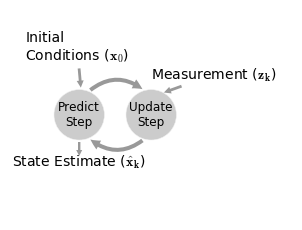

In [20]:
book_plots.create_predict_update_chart()

Let me introduce some more formal terminology. The *system* is the object that we want to estimate. In this chapter the system is whatever we are trying to weigh. Some texts call this the *plant*. That terminology comes from control system theory. https://en.wikipedia.org/wiki/Plant_(control_theory%29

The *state* of the system is the current configuration or values of that system that is of interest to us. We are interested only in the weight reading. If I put a 100 kg weight on the scale, the state is 100kg. We define the state based on what is relevant to us. The color of the scale is irrelevant to us so we do not include those values in the state. A QA engineer for the manufacturer might include color in the state so that she can track and control the manufacturing process. The *state estimate* is our filter's estimate of the state. For example, for the 100 kg weight our estimate might be 99.327 kg due to sensor errors.

We use a *process model* to mathematically model the system. In this chapter our process model is the assumption that my weight today is yesterday's weight plus my weight gain for the last day. The process model does not model or otherwise account for the sensors. Another example would be a process model for an automobile. The process model might be "distance equals velocity times time. This model is not perfect as the velocity of a car can vary over a non-zero amount of time, the tires can slip on the road, and so on. The *system error* or *process error* is the error in this model. We never know this value exactly; if we did we could refine our model to have zero error. Some texts use *plant model* and *plant error*. You may also see *system model*. They all mean the same thing.

The predict step is known as *system propagation*. It uses the *process model* to form a new *state estimate*. Because of the *process error* this estimate is imperfect. Assuming we are tracking data over time, we say we *propagate* the state into the future. Some texts call this the *evolution*. 

The update step is known as the *measurement update*. One iteration of the system propagation and measurement update is known as an *epoch*. 

Now let's explore a few different problem domains to better understand this algorithm. Consider the problem of trying to track a train on a track. The track constrains the position of the train to a very specific region. Furthermore, trains are large and slow. It takes them many minutes to slow down or speed up significantly. So, if I know that the train is at kilometer marker 23 km at time t and moving at 18 kph, I can be extremely confident in predicting its position at time t + 1 second. And why is that important? Suppose we can only measure its position with an accuracy of $\pm$ 250 meters. The train is moving at 18 kph, which is 5 meters per second. At t+1 seconds the train will be at 23.005 km yet the measurement could be anywhere from 22.755 km to 23.255 km. So if the next measurement says the position is at 23.4 we know that must be wrong. Even if at time t the engineer slammed on the brakes the train will still be very close to 23.005 km because a train cannot slow down very much in 1 second. If we were to design a filter for this problem (and we will a bit further in the chapter!) we would want to design a filter that gave a very high weighting to the prediction vs the measurement. 

Now consider the problem of tracking a thrown ball. We know that a ballistic object moves in a parabola in a vacuum when in a gravitational field. But a ball thrown on the surface of the Earth is influenced by air drag, so it does not travel in a perfect parabola. Baseball pitchers take advantage of this fact when they throw curve balls. Let's say that we are tracking the ball inside a stadium using computer vision. The accuracy of the computer vision tracking might be modest, but predicting the ball's future positions by assuming that it is moving on a parabola is not extremely accurate either. In this case we'd probably design a filter that gave roughly equal weight to the measurement and the prediction.

Now consider trying to track a child's balloon in a hurricane. We have no legitimate model that would allow us to predict the balloon's behavior except over very brief time scales (we know the balloon cannot go 10 miles in 1 second, for example). In this case we would design a filter that emphasized the measurements over the predictions.

Most of this book is devoted to expressing the concerns in the last three paragraphs mathematically, which then allows us to find an optimal solution. In this chapter we will merely be assigning different values to $g$ and $h$ in a more intuitive, and thus less optimal way. But the fundamental idea is to blend somewhat inaccurate measurements with somewhat inaccurate models of how the systems behaves to get a filtered estimate that is better than either information source by itself.

We can express this as an algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state

**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. New estimate is somewhere on the residual line
    
We will use this same algorithm throughout the book, albeit with some modifications. 

## Notation

I'll begin to introduce the notations and variable names used in the literature. Some of this was already used in the above charts. Measurement is typically denoted $z$ and that is what we will use in this book (some literature uses $y$). Subscript $k$ indicates the time step, so $z_k$ is the data for this time step. A bold font denotes a vector or matrix. So far we have only considered having one sensor, and hence one sensor measurement, but in general we may have *n* sensors and *n* measurements. $\mathbf{x}$ denotes our state, and is bold to denote that it is a vector. For our scale example, it represents both the initial weight and initial weight gain rate, like so:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

For a weight of 62 kg with a gain of 0.3 kg/day we have

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

So, the algorithm is simple. The state is initialized with $\mathbf{x_0}$, the initial estimate. We then enter a loop, predicting the state for time or step $k$ from the values from time (or step) $k-1$. We then get the measurement $z_k$ and choose some intermediate point between the measurements and prediction, creating the estimate $\mathbf{x}_k$.

## NumPy arrays

I use NumPy's array data structure throughout the book, so let's learn about them now. I will teach you enough to get started; refer to NumPy's documentation if you want to become an expert.

`numpy.array` implements a one or more dimensional array. Its type is `numpy.ndarray`, and we will refer to this as an ndarray for short. You can construct it with any list-like object. The following constructs a 1-D array from a list:

In [21]:
import numpy as np
x = np.array([1, 2, 3])
print(type(x))
x

<class 'numpy.ndarray'>


array([1, 2, 3])

You can also use tuples:

In [22]:
x = np.array((4,5,6))
x

array([4, 5, 6])

In [23]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])
print(x)

[[1 2 3]
 [4 5 6]]


You can create arrays of 3 or more dimensions, but we have no need for that here, and so I will not elaborate.

By default the arrays use the data type of the values in the list; if there are multiple types then it will choose the type that most accurately represents all the values. So, for example, if your list contains a mix of `int` and `float` the data type of the array would be of type `float`. You can override this with the `dtype` parameter.

In [24]:
x = np.array([1, 2, 3], dtype=float)
print(x)

[ 1.0  2.0  3.0]


You can access the array elements using subscript location:

In [25]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])

print(x[1,2])

6


You can access a column or row by using slices. A ':' used as a subscript is shorthand for all data in that row or column. So `x[:,0]` returns an array of all data in the first column (the 0 specifies the first column):

In [26]:
x[:, 0]

array([1, 4])

We can get the second row with:

In [27]:
x[1, :]

array([4, 5, 6])

You can perform matrix addition with the `+` operator, but matrix multiplication requires the `dot` method or function. The `*` operator performs element-wise multiplication, which is **not** what you want for linear algebra.

In [28]:
x = np.array([[1., 2.],
              [3., 4.]])
print('addition:\n', x+x)
print('\nelement-wise multiplication\n', x*x)
print('\nmultiplication\n', np.dot(x,x))
print('\ndot is also a member of np.array\n', x.dot(x))

addition:
 [[ 2.0  4.0]
 [ 6.0  8.0]]

element-wise multiplication
 [[ 1.0  4.0]
 [ 9.0  16.0]]

multiplication
 [[ 7.0  10.0]
 [ 15.0  22.0]]

dot is also a member of np.array
 [[ 7.0  10.0]
 [ 15.0  22.0]]


You can get the transpose with `.T`, and the inverse with `numpy.linalg.inv`.

In [29]:
print('transpose\n', x.T)
print('\ninverse\n', np.linalg.inv(x))

transpose
 [[ 1.0  3.0]
 [ 2.0  4.0]]

inverse
 [[ -2.0  1.0]
 [ 1.5  -0.5]]


Finally, there are helper functions like `zeros` to create a matrix of all zeros, `ones` to get all ones, and `eye` to get the identity matrix. If you want a multidimensional array, use a tuple to specify the shape.

In [30]:
print('zeros\n', np.zeros(7))
print('\nzeros(3x2)\n', np.zeros((3, 2)))
print('\neye\n', np.eye(3))

zeros
 [ 0.0  0.0  0.0  0.0  0.0  0.0  0.0]

zeros(3x2)
 [[ 0.0  0.0]
 [ 0.0  0.0]
 [ 0.0  0.0]]

eye
 [[ 1.0  0.0  0.0]
 [ 0.0  1.0  0.0]
 [ 0.0  0.0  1.0]]


NumPy is part of the SciPy package. Both are well documented. You can find a tutorial and links to the full documentation at the following location:

https://docs.scipy.org/doc/numpy-dev/user/quickstart.html

### Exercise -  Create arrays

I want you to create a NumPy array of 10 elements with each element containing 1/10. There are several ways to do this; try to implement as many as you can think of. 

In [31]:
# your solution

### Solution

Here are three ways to do this. The first one is the one I want you to know. I used the '/' operator to divide all of the elements of the array with 10. We will shortly use this to convert the units of an array from meters to km.

In [32]:
print(np.ones(10) / 10.)
print(np.array([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1]))
print(np.array([.1]*10))

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


Here is one I haven't covered yet. The function `numpy.asarray()` will convert its argument to an ndarray if it isn't already one. If it is, the data is unchanged. This is a handy way to write a function that can accept either Python lists or ndarrays, and it is very efficient if the type is already ndarray as nothing new is created.

In [33]:
def one_tenth(x):
    x = np.asarray(x)
    return x / 10.

print(one_tenth([1, 2, 3]))            # I work!
print(one_tenth(np.array([4, 5, 6])))  # so do I!

[ 0.1  0.2  0.3]
[ 0.4  0.5  0.6]


## Exercise: Write Generic Algorithm

In the example above, I explicitly coded this to solve the weighing problem that we've been discussing throughout the chapter. For example, the variables are named "weight_scale", "gain", and so on. I did this to make the algorithm easy to follow - you can easily see that we correctly implemented each step. But, that is code written for exactly one problem, and the algorithm is the same for any problem. So let's rewrite the code to be generic - to work with any problem. Use this function signature:

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

Return the data as a NumPy array, not a list. Test it by passing in the same weight data as before, plot the results, and visually determine that it works.

In [34]:
#with interactive_plot():
#    # your solution here
#    pass

### Solution and Discussion

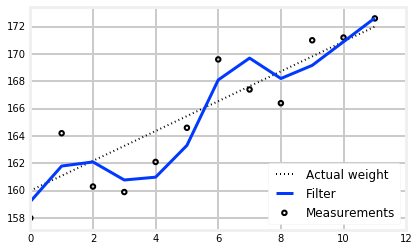

In [35]:
from kf_book.gh_internal import plot_g_h_results

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x = x0
    results = []
    for z in data:
        #prediction step
        x_est = x + (dx*dt)
        dx = dx

        # update step
        residual = z - x_est
        dx = dx    + h * (residual) / dt
        x  = x_est + g * residual     
        results.append(x)  
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

## Choice of g and h

The g-h filter is not one filter - it is a classification for a family of filters. Eli Brookner in *Tracking and Kalman Filtering Made Easy* lists 11, and I am sure there are more. Not only that, but each type of filter has numerous subtypes. Each filter is differentiated by how $g$ and $h$ are chosen. So there is no 'one size fits all' advice that I can give here. Some filters set $g$ and $h$ as constants, others vary them dynamically. The Kalman filter varies them dynamically at each step. Some filters allow $g$ and $h$ to take any value within a range, others constrain one to be dependent on the other by some function $f(\dot{}), \mbox{where }g = f(h)$.

The topic of this book is not the entire family of g-h filters; more importantly, we are interested in the *Bayesian* aspect of these filters, which I have not addressed yet. Therefore I will not cover selection of $g$ and $h$ in depth. *Tracking and Kalman Filtering Made Easy* is an excellent resource for that topic. If this strikes you as an odd position for me to take, recognize that the typical formulation of the Kalman filter does not use $g$ and $h$ at all. The Kalman filter is a g-h filter because it mathematically reduces to this algorithm. When we design the Kalman filter we use design criteria that can be mathematically reduced to $g$ and $h$, but the Kalman filter form is usually a much more powerful way to think about the problem. Don't worry if this is not too clear right now, it will be much clearer later after we develop the Kalman filter theory.

It is worth seeing how varying $g$ and $h$ affects the results, so we will work through some examples. This will give us strong insight into the fundamental strengths and limitations of this type of filter, and help us understand the behavior of the rather more sophisticated Kalman filter.

## Exercise: create measurement function

Now let's write a function that generates noisy data for us. In this book I model a noisy signal as the signal plus [white noise](https://en.wikipedia.org/wiki/White_noise). We've not yet covered the statistics to fully understand the definition of white noise. In essence, think of it as data that randomly varies higher and lower than the signal with no pattern. We say that it is a serially uncorrelated random variable with zero mean and finite variance. If you don't follow that, you will by the end of the *Gaussians* chapter. You may not be successful at this exercise if you have no knowledge of statistics. If so, just read the solution and discussion.

White noise can be generated by `numpy.random.randn()`. We want a function that we call with the starting value, the amount of change per step, the number of steps, and the amount of noise we want to add. It should return a list of the data. Test it by creating 30 points, filtering it with `g_h_filter()`, and plot the results with `plot_g_h_results()`.

In [36]:
# your code here

### Solution

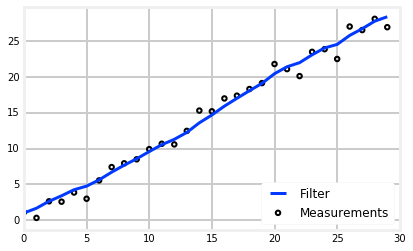

In [37]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### Discussion

`randn()` returns random numbers centered around 0 - it is just as likely to be greater than zero as under zero. It varies by *one standard deviation* - don't worry if you don't know what that means. I've plotted 3000 calls to `randn()` - you can see that the values are centered around zero and mostly range from a bit under -1 to a bit more than +1, though occasionally they are much larger.

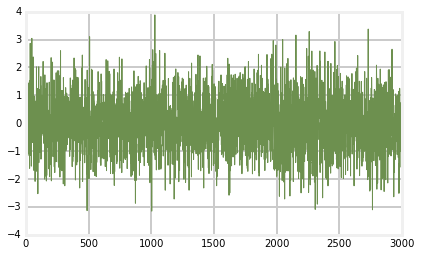

In [38]:
plt.plot([randn() for _ in range(3000)], lw=1);

## Exercise: Bad Initial Conditions

Now write code that uses `gen_data` and `g_h_filter` to filter 100 data points that starts at 5, has a derivative of 2, a noise scaling factor of 10, and uses g=0.2 and h=0.02. Set you initial guess for x to be 100.

In [39]:
# your code here

### Solution and Discussion

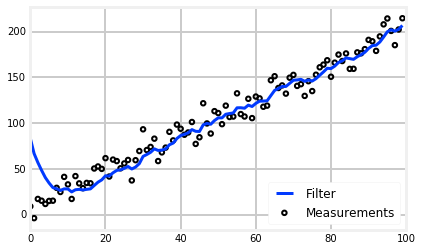

In [40]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.01)
plot_g_h_results(measurements=zs, filtered_data=data)

The filter starts out with estimates that are far from the measured data due to the bad initial guess of 100. You can see that it 'rings' before settling in on the measured data. 'Ringing' means that the signal overshoots and undershoots the data in a sinusoidal type pattern. This is a very common phenomena in filters, and a lot of work in filter design is devoted to minimizing ringing. That is a topic that we are not yet prepared to address, but I wanted to show you the phenomenon.

## Exercise: Extreme Noise

Rerun the same test, but this time use a noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.

In [41]:
# your code here

### Solution and Discussion

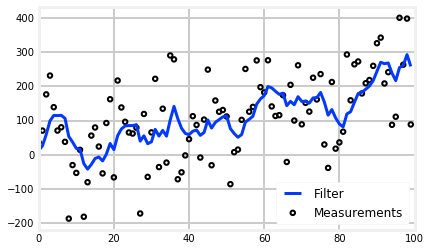

In [42]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

This doesn't look so wonderful to me. We can see that perhaps the filtered signal varies less than the noisy signal, but it is far from the straight line. If we were to plot just the filtered result no one would guess that the signal starts at 5 and increments by 2 at each time step. And while in locations the filter does seem to reduce the noise, in other places it seems to overshoot and undershoot.

At this point we don't know enough to really judge this. We added **a lot** of noise; maybe this is as good as filtering can get. However, the existence of the multitude of chapters beyond this one should suggest that we can do much better.

## Exercise: The Effect of Acceleration

Write a new data generation function that adds in a constant acceleration factor to each data point. In other words, increment dx as you compute each data point so that the velocity (dx) is ever increasing. Set the noise to 0, $g=0.2$ and $h=0.02$ and plot the results. Explain what you see.

In [43]:
# your code here

### Solution and Discussion

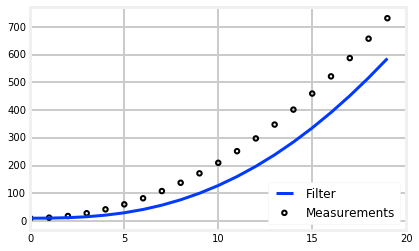

In [44]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

Each prediction lags behind the signal. If you think about what is happening this makes sense. Our model assumes that velocity is constant. The g-h filter computes the first derivative of $x$ (we use $\dot{x}$ to denote the derivative) but not the second derivative $\ddot{x}$. So we are assuming that $\ddot{x}=0$. At each prediction step we predict the new value of x as $x + \dot{x}*t$. But because of the acceleration the prediction must necessarily fall behind the actual value. We then try to compute a new value for $\dot{x}$, but because of the $h$ factor we only partially adjust $\dot{x}$ to the new velocity. On the next iteration we will again fall short.

Note that there is no adjustment to $g$ or $h$ that we can make to correct this problem. This is called the *lag error* or *systemic error* of the system. It is a fundamental property of g-h filters. Perhaps your mind is already suggesting solutions or workarounds to this problem. As you might expect, a lot of research has been devoted to this problem, and we will be presenting various solutions to this problem in this book.
> The 'take home' point is that the filter is only as good as the mathematical model used to express the system. 

## Exercise: Varying g

Now let's look at the effect of varying g. Before you perform this exercise, recall that g is the scale factor for choosing between the measurement and prediction. What do you think the effect of a large value of g will be? A small value? 

Now, let the `noise_factor=50` and `dx=5`. Plot the results of $g = 0.1\mbox{, } 0.4,\mbox{ and } 0.8$.

In [45]:
# your code here

### Solution and Discussion

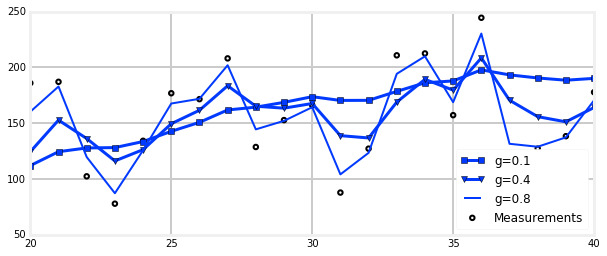

In [46]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, lw=1, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s')
    book_plots.plot_filter(data2, label='g=0.4', marker='v')
    book_plots.plot_filter(data3, label='g=0.8', lw=2)
    plt.legend(loc=4)
    book_plots.set_limits([20,40], [50, 250])

It is clear that as $g$ is larger we more closely follow the measurement instead of the prediction. When $g=0.8$ we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that $g$ should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction. What happens when the signal changes not due to noise, but an actual state change? Let's have a look. I will create data that has $\dot{x}=1$ for 9 steps before changing to $\dot{x}=0$. 

(6, 20)

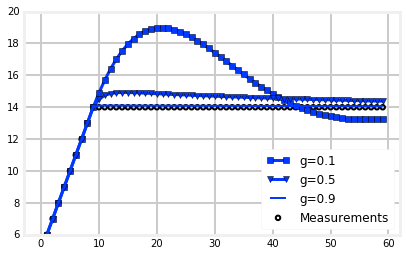

In [47]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s')
book_plots.plot_filter(data2, label='g=0.5', marker='v')
book_plots.plot_filter(data3, label='g=0.9', lw=2)
plt.legend(loc=4)
plt.ylim([6, 20])

Here we can see the effects of ignoring the signal. We not only filter out noise, but legitimate changes in the signal as well. 

Maybe we need a 'Goldilocks' filter, where is not too large, not too small, but just right? Well, not exactly. As alluded to earlier, different filters choose g and h in different ways depending on the mathematical properties of the problem. For example, the Benedict-Bordner filter was invented to minimize the transient error in this example, where $\dot{x}$ makes a step jump. We will not discuss this filter in this book, but here are two plots chosen with different allowable pairs of g and h. This filter design minimizes transient errors for step jumps in $\dot{x}$ at the cost of not being optimal for other types of changes in $\dot{x}$.

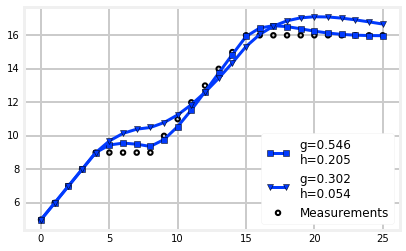

In [48]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546\nh=0.205', marker='s')
book_plots.plot_filter(data1, label='g=0.302\nh=0.054', marker='v')
plt.legend(loc=4);

## Varying h

Now let's leave g unchanged and investigate the effect of modifying h. We know that h affects how much we favor the measurement of $\dot{x}$ vs our prediction. But what does this *mean*? If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those transient changes rapidly. A smaller $h$ will cause us to react more slowly.

We will look at three examples. We have a noiseless measurement that slowly goes from 0 to 1 in 50 steps. Our first filter uses a nearly correct initial value for $\dot{x}$ and a small $h$. You can see from the output that the filter output is very close to the signal. The second filter uses the very incorrect guess of $\dot{x}=2$. Here we see the filter 'ringing' until it settles down and finds the signal. The third filter uses the same conditions but it now sets $h=0.5$. If you look at the amplitude of the ringing you can see that it is much smaller than in the second chart, but the frequency is greater. It also settles down a bit quicker than the second filter, though not by much.

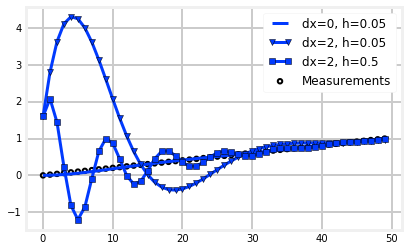

In [49]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s')
plt.legend(loc=1);

## Interactive Example

For those of you running this in Jupyter Notebook I've written an interactive version of the filter so you can see the effect of changing $\dot{x}$, $g$ and $h$ in real time. As you adjust the sliders for $\dot{x}$, $g$ and $h$ the date will be refiltered and the results plotted for you.

If you really want to test yourself, read the next paragraph and try to predict the results before you move the sliders. 

Some things to try include setting $g$  and $h$ to their minimum values. See how perfectly the filter tracks the data! This is only because we are perfectly predicting the weight gain. Adjust $\dot{x}$ to larger or smaller than 5. The filter should diverge from the data and never reacquire it. Start adding back either $g$ or $h$ and see how the filter snaps back to the data. See what the difference in the line is when you add only $g$ vs only $h$. Can you explain the reason for the difference? Then try setting $g$ greater than 1. Can you explain the results? Put $g$ back to a reasonable value (such as 0.1), and then make $h$ very large. Can you explain these results? Finally, set both $g$ and $h$ to their largest values. 
 
If you want to explore with this more, change the value of the array `zs` to the values used in any of the charts above and rerun the cell to see the result.

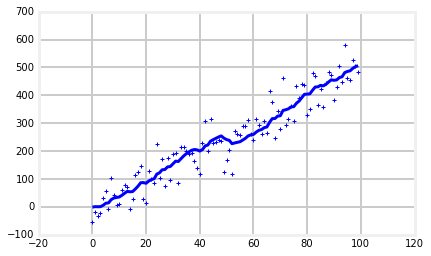

In [50]:
from ipywidgets import interact, FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                marker='+', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0., min=-200, max=200., continuous_update=False), 
         dx=FloatSlider(value=5., min=-50., max=50., continuous_update=False), 
         g=FloatSlider(value=0.1, min=0.01, max=2, step=.02, continuous_update=False), 
         h=FloatSlider(value=0.02, min=0.0, max=0.5, step=0.01, continuous_update=False));

## Don't Lie to the Filter

You are free to set $g$ and $h$ to any value. Here is a filter that performs perfectly despite extreme noise.

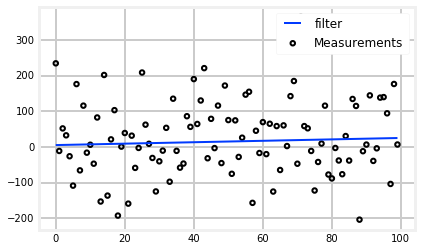

In [51]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter', lw=2)
plt.legend(loc=1);

I brilliantly extracted a straight line out of very noisy data! Maybe I shouldn't try to collect my Fields Medal in mathematics just yet. I did this by setting both $g$ and $h$ to 0. What does this do? It makes the filter ignore the measurements, and so for each update it computes the new position as $x + \Delta x \Delta t$. Of course the result is a straight line if we ignore the measurements. 

A filter that ignores measurements is useless. I know you would never set both $g$ and $h$ to zero as that takes a special kind of genius that only I possess, but I promise that if you are not careful you will set them lower than they should be. You can always make great looking results from test data. When you try your filter on different data you will be disappointed in the results because you finely tuned the constants for a specific data set. $g$ and $h$ must reflect the real world behavior of the system you are filtering, not the behavior of one specific data set. In later chapters we will learn a lot about how to do that. For now I can only say be careful, or you will be getting perfect results with your test data, but results like this once you switch to real data:

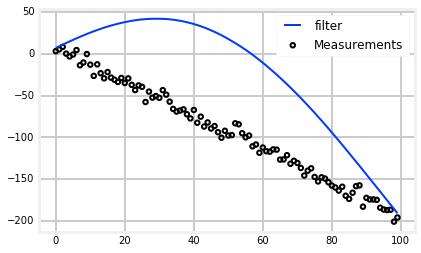

In [52]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter', lw=2)
plt.legend(loc=1);

## Tracking a Train

We are ready for a practical example. Earlier in the chapter we talked about tracking a train. Trains are heavy and slow, thus they cannot change speed quickly. They are on a track, so they cannot change direction except by slowing to a stop and then reversing course. Hence, we can conclude that if we already know the train's approximate position and velocity then we can predict its position in the near future with a great deal of accuracy. A train cannot change its velocity much in a second or two. 

So let's write a filter for a train. Its position is expressed as its position on the track in relation to some fixed point which we say is 0 km. I.e., a position of 1 means that the train is 1 km away from the fixed point. Velocity is expressed as meters per second. We perform measurement of position once per second, and the error is $\pm$ 500 meters. How should we implement our filter?

First, let's simulate the situation without a filter. We will assume that the train is currently at kilometer 23, and moving at 15 m/s. We can code this as 

```python
pos = 23*1000
vel = 15
```

Now we can compute the position of the train at some future time, *assuming* no change in velocity, with

```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```

We can simulate the measurement by adding in some random noise to the position. Here our error is 500m, so the code might look like:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
        
Let's put that in a cell and plot the results of 100 seconds of simulation. I will use NumPy's `asarray` function to convert the data into an NumPy array. This will allow me to divide all of the elements of the array at once by using the '/' operator.

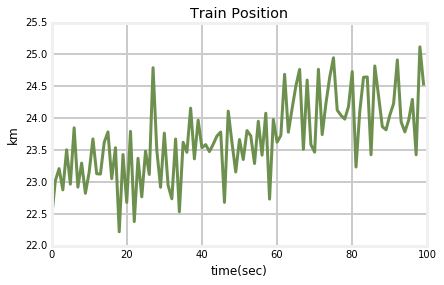

In [53]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

We can see from the chart how poor the measurements are. No real train could ever move like that. 

So what should we set $g$ and $h$ to if we want to filter this data? We have not developed the theory for this, but let's try to get a reasonable answer by the seat of our pants. We know that the measurements are very inaccurate, so we don't want to give them much weight at all. To do this we need to choose a very small $g$. We also know that trains can not accelerate or decelerate quickly, so we also want a very small $h$. For example:

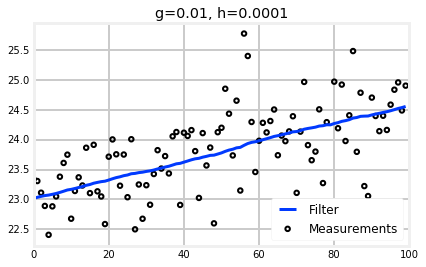

In [54]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

That is pretty good for an initial guess. Let's make $g$ larger to see the effect.

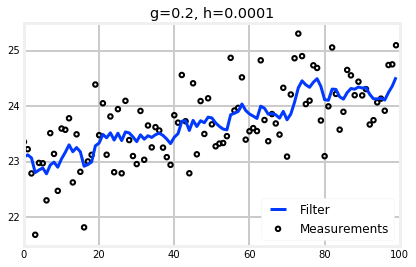

In [55]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

We made `g=0.2` and we can see that while the train's position is smoothed, the estimated position (and hence velocity) fluctuates a lot in a very tiny frame, far more than a real train can do. So empirically we know that we want `g<<0.2`.

Now let's see the effect of a poor choice for $h$.

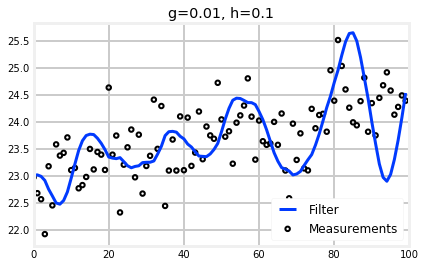

In [56]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

Here the position changes smoothly thanks to the small $g$, but the large $h$ makes the filter very reactive to the measurements. This happens because in the course of a few seconds the rapidly changing measurement implies a very large velocity change, and a large $h$ tells the filter to react to those changes quickly. Trains cannot change velocity quickly, so the filter is not doing a good job of filtering the data - the filter is changing velocity faster than a train can.

Finally, let's add some acceleration to the train. I don't know how fast a train can actually accelerate, but let's say it is accelerating at 0.2 m/sec^2. 

In [57]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

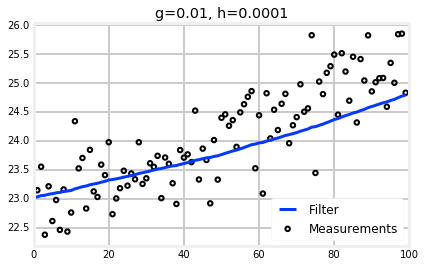

In [58]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Here we see that the filter is not quite tracking the train anymore due to the acceleration. We can fiddle with $h$ to let it track better, at the expense of a less smooth filtered estimate.

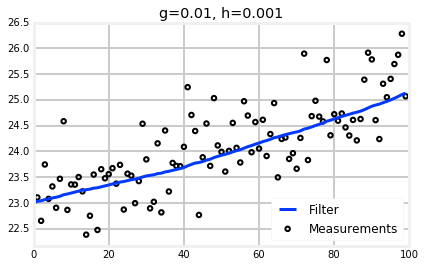

In [59]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

There are two lessons to be learned here. First, use the $h$ term to respond to changes in velocity that you are not modeling. But, far more importantly, there is a trade off here between responding quickly and accurately to changes in behavior and producing ideal output for when the system is in a steady state that you have. If the train never changes velocity we would make $h$ extremely small to avoid having the filtered estimate unduly affected by the noise in the measurement. But in an interesting problem there are almost always changes in state, and we want to react to them quickly. The more quickly we react to them, the more we are affected by the noise in the sensors. 

I could go on, but my aim is not to develop g-h filter theory here so much as to build insight into how combining measurements and predictions leads to a filtered solution. There is extensive literature on choosing $g$ and $h$ for problems such as this, and there are optimal ways of choosing them to achieve various goals. As I explained earlier it is easy to 'lie' to the filter when experimenting with test data like this. In the subsequent chapters we will learn how the Kalman filter solves this problem in the same basic manner, but with far more sophisticated mathematics. 

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) is an open source filtering library that I wrote. It has all of the filters in this book, along with others. It is rather easy to program your own g-h filter, but as we progress we will rely on FilterPy more. As a quick introduction, let's look at the g-h filter in FilterPy.

If you do not have FilterPy installed just issue the following command from the command line.

    pip install filterpy
    
Read Appendix A for more information on installing or downloading FilterPy from GitHub.

To use the g-h filter import it and create an object from the class `GHFilter`. 

In [60]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

When you construct the object you specify the initial value and rate of change for the signal (`x` and 'dx'), the time step between updates(`dt`) and the two filter parameter (`g` and `h`). `dx` must have the same units of `x`/`dt` - if `x` is in meters and `dt` is in seconds then `dx` must be in meters per second.

To run the filter call update, passing the measurement in the parameter `z`.

In [61]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [62]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [63]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [64]:
print(f.batch_filter([3., 4., 5.]))

[[ 1.97  0.375]
 [ 2.87  0.507]
 [ 3.88  0.632]
 [ 4.9  0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [65]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [ 3.8  13.2  1.02e+02]
dx = [ 8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

## Summary

I encourage you to experiment with this filter to develop your understanding of how it reacts. It shouldn't take too many attempts to come to the realization that ad-hoc choices for $g$ and $h$ do not perform very well. A particular choice might perform well in one situation, but very poorly in another. Even when you understand the effect of $g$ and $h$ it can be difficult to choose proper values. In fact, it is extremely unlikely that you will choose values for $g$ and $h$ that is optimal for any given problem. Filters are *designed*, not selected *ad hoc*. 

In some ways I do not want to end the chapter here, as there is a significant amount that we can say about selecting $g$ and $h$. But the g-h filter in this form is not the purpose of this book. Designing the Kalman filter requires you to specify a number of parameters - indirectly they do relate to choosing $g$ and $h$, but you will never refer to them directly when designing Kalman filters. Furthermore, $g$ and $h$ will vary at every time step in a very non-obvious manner. 

There is another feature of these filters we have barely touched upon - Bayesian statistics. You will note that the term 'Bayesian' is in the title of this book; this is not a coincidence! For the time being we will leave $g$ and $h$ behind, largely unexplored, and develop a very powerful form of probabilistic reasoning about filtering. Yet suddenly this same g-h filter algorithm will appear, this time with a formal mathematical edifice that allows us to create filters from multiple sensors, to accurately estimate the amount of error in our solution, and to control robots.